In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense

from datetime import datetime

In [ ]:
#Customize functions

In [4]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

    
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

In [ ]:
#preprocessing data

In [5]:
def preprocess_inputs(df, task='classification'):
    df = df.copy()
    
    if task == 'classification':
        df = df.drop('stab', axis=1)
        
        y = df['stabf'].copy()
        X = df.drop('stabf', axis=1).copy()
        
    elif task == 'regression':
        df = df.drop('stabf', axis=1)
        
        y = df['stab'].copy()
        X = df.drop('stab', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    return X_train, X_test, y_train, y_test

In [ ]:
#Augmented Dataset with 60 000 observations

In [6]:
sns.set()

data = pd.read_csv('../input/smart-grid-stability/smart_grid_stability_augmented.csv')

map1 = {'unstable': 0, 'stable': 1}
data['stabf'] = data['stabf'].replace(map1)

data = data.sample(frac=1)

In [ ]:
#Data Exploration

In [7]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
31442,0.678286,9.346392,2.510695,6.181783,3.339107,-1.208540,-0.834340,-1.296226,0.795541,0.785380,0.721275,0.504192,-0.008306,1
15907,5.078591,6.091427,9.809353,7.121842,3.677701,-1.623400,-1.088588,-0.965713,0.523734,0.516529,0.089201,0.168762,0.003933,0
6576,5.246756,6.399746,3.566318,1.571734,4.184347,-1.032613,-1.828043,-1.323691,0.740374,0.885150,0.104556,0.428917,0.034424,0
18038,0.927524,6.064315,7.481941,3.141760,4.052363,-0.873078,-1.953940,-1.225345,0.843267,0.339222,0.488210,0.503167,-0.032497,1
47869,4.682806,8.037218,4.716318,8.994294,4.246033,-1.738297,-1.079232,-1.428504,0.804285,0.768807,0.667648,0.715903,0.079585,0


In [8]:
data.isna()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
31442,False,False,False,False,False,False,False,False,False,False,False,False,False,False
15907,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6576,False,False,False,False,False,False,False,False,False,False,False,False,False,False
18038,False,False,False,False,False,False,False,False,False,False,False,False,False,False
47869,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53025,False,False,False,False,False,False,False,False,False,False,False,False,False,False
48562,False,False,False,False,False,False,False,False,False,False,False,False,False,False
15366,False,False,False,False,False,False,False,False,False,False,False,False,False,False
21831,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [9]:
data.shape

(60000, 14)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 31442 to 13867
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 6.9 MB


In [11]:
data.iloc[[1,3],:]

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
15907,5.078591,6.091427,9.809353,7.121842,3.677701,-1.623400,-1.088588,-0.965713,0.523734,0.516529,0.089201,0.168762,0.003933,0
18038,0.927524,6.064315,7.481941,3.141760,4.052363,-0.873078,-1.953940,-1.225345,0.843267,0.339222,0.488210,0.503167,-0.032497,1


In [12]:
data.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731,0.362000
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917,0.480583
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760,0.000000
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557,0.000000
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142,0.000000
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878,1.000000
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403,1.000000


In [11]:
print(data.isnull())

        tau1   tau2   tau3   tau4     p1     p2     p3     p4     g1     g2  \
46420  False  False  False  False  False  False  False  False  False  False   
58246  False  False  False  False  False  False  False  False  False  False   
24484  False  False  False  False  False  False  False  False  False  False   
10078  False  False  False  False  False  False  False  False  False  False   
15882  False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
11330  False  False  False  False  False  False  False  False  False  False   
48317  False  False  False  False  False  False  False  False  False  False   
45741  False  False  False  False  False  False  False  False  False  False   
12845  False  False  False  False  False  False  False  False  False  False   
24561  False  False  False  False  False  False  False  False  False  False   

          g3     g4   stab  stabf  
46420  False  F

In [13]:
print(data.isnull().sum())

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64


In [14]:
data = data.dropna() 

In [ ]:
# Feature assessment
#Distribution patterns and the relationship with the 'stab' dependent variable is charted for each of the 12 dataset features.

#As this data comes from simulations with predetermined fixed ranges for all features, as described in Section 3,
#distributions are pretty much uniform across the board, with the exception of 'p1' (absolute sum of 'p2', 'p3' and 'p4'), 
#which follows a normal distribution (as expected) with a very small skew factor of -0.013.

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


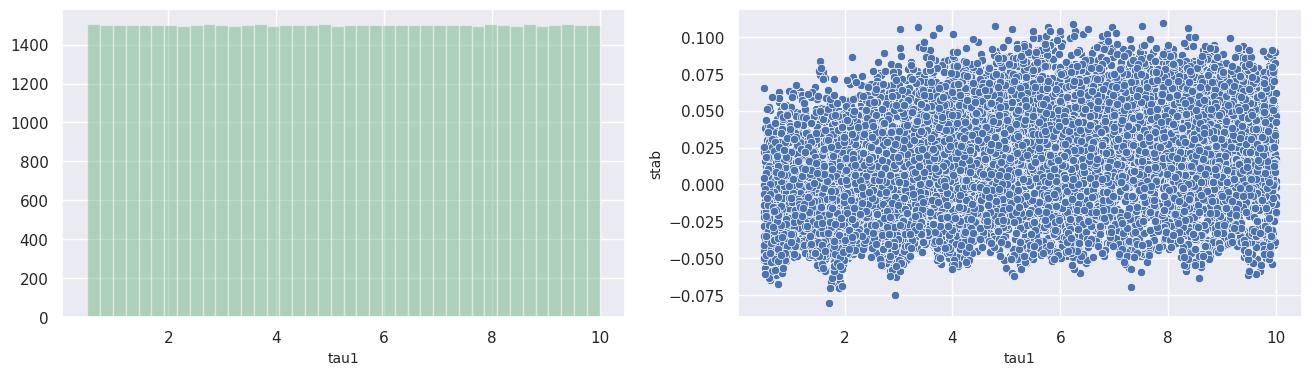

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


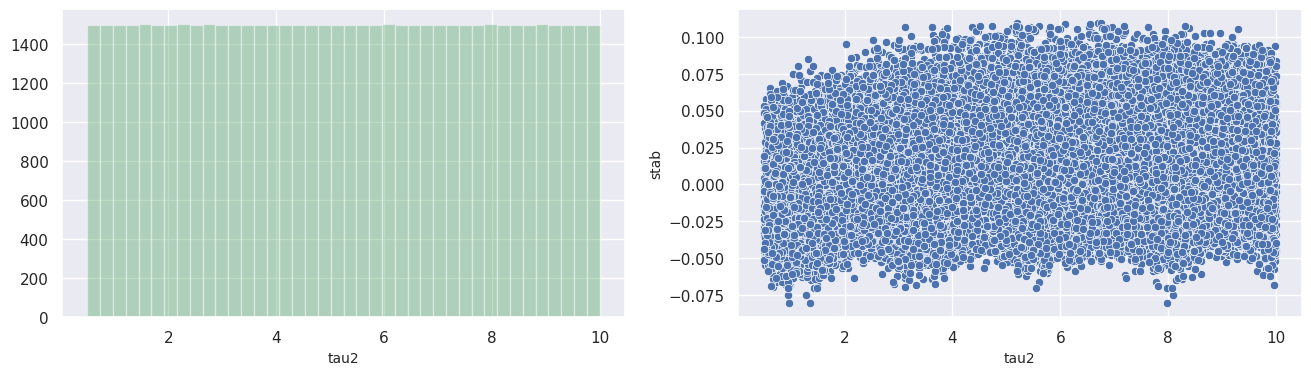

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


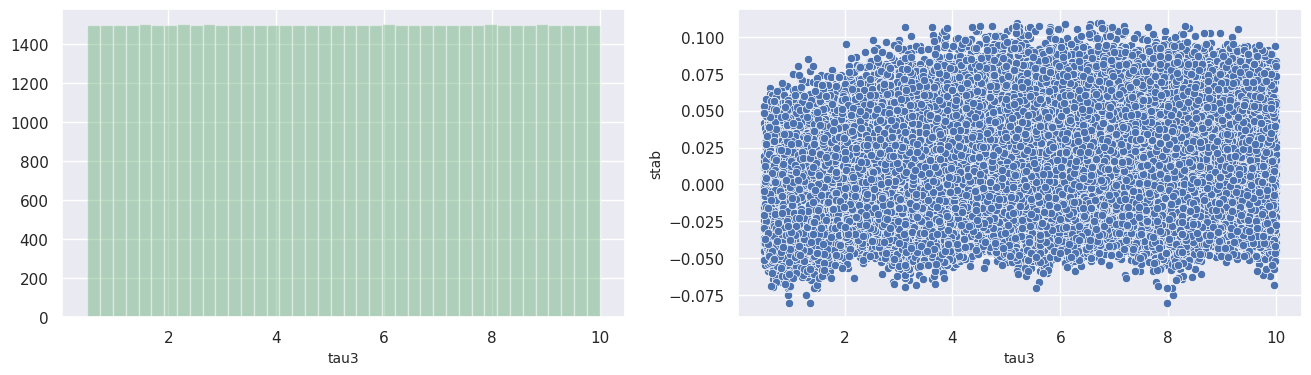

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


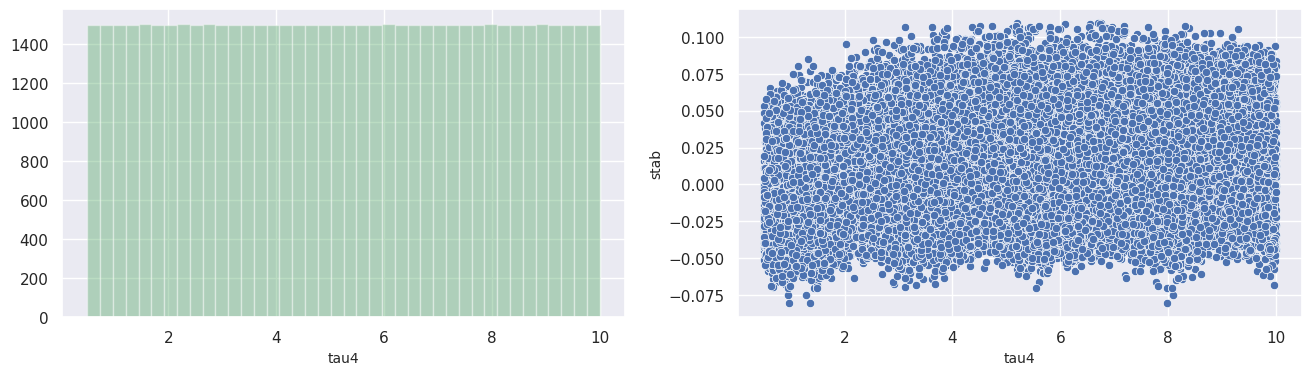

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


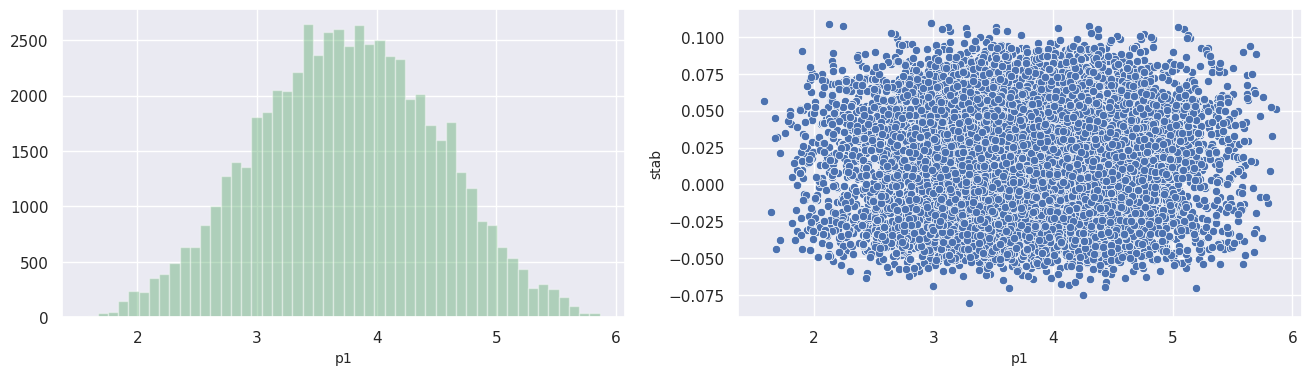

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


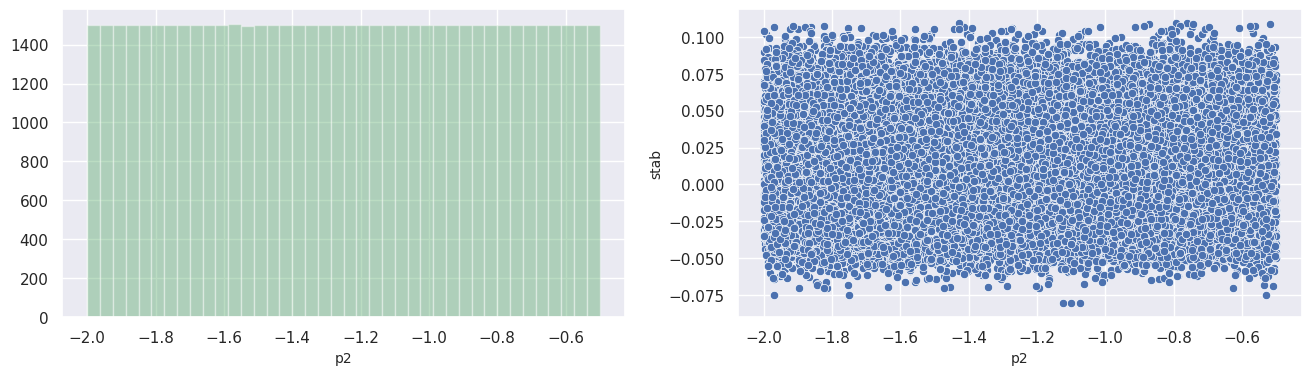

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


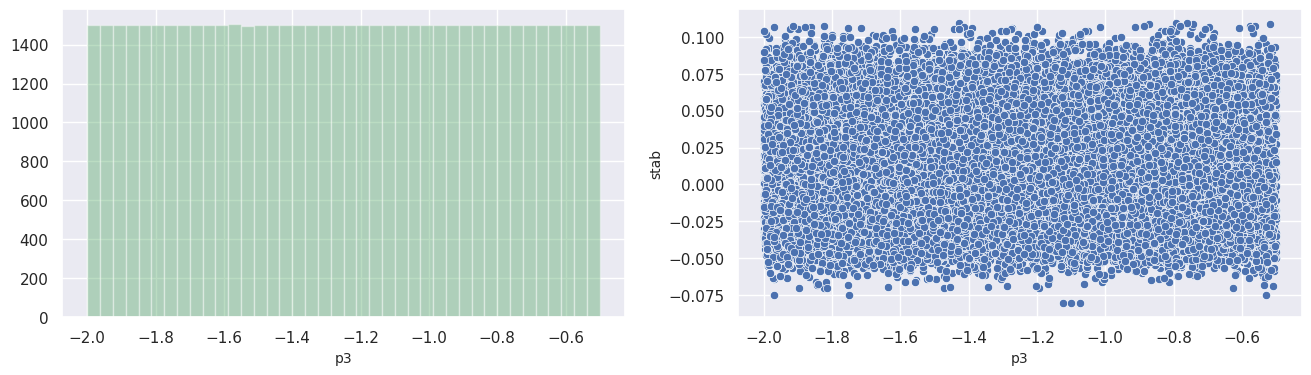

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


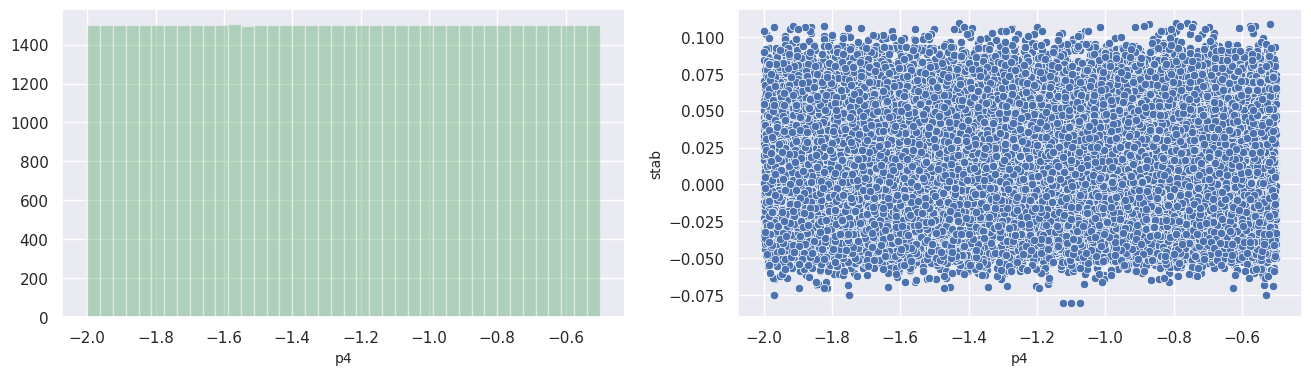

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


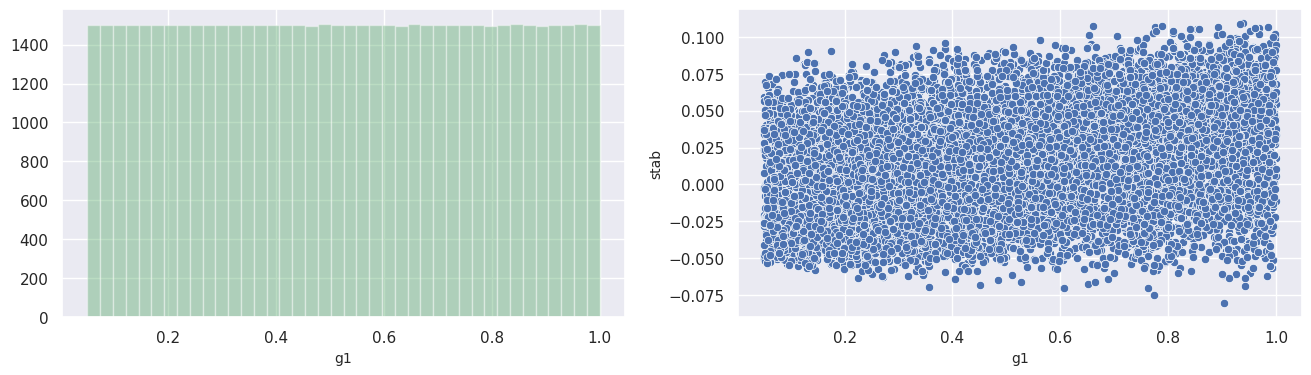

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


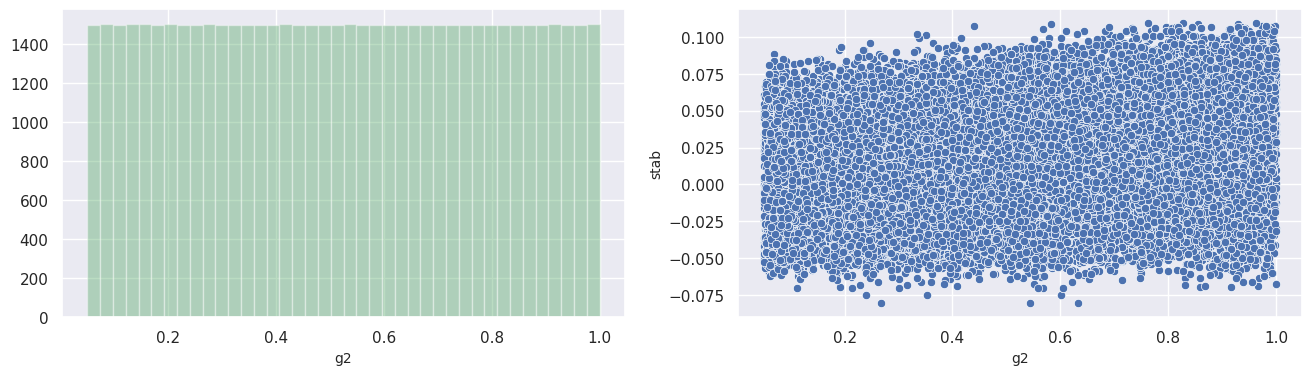

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


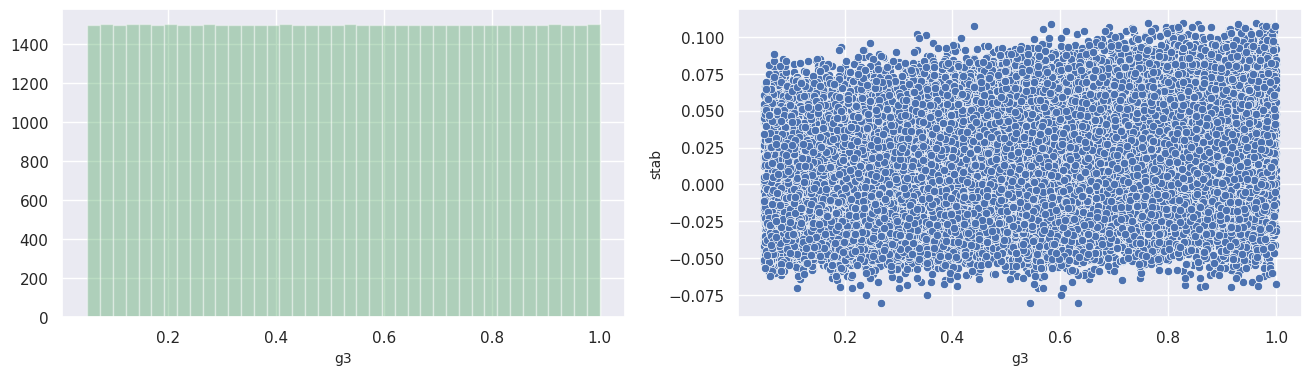

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


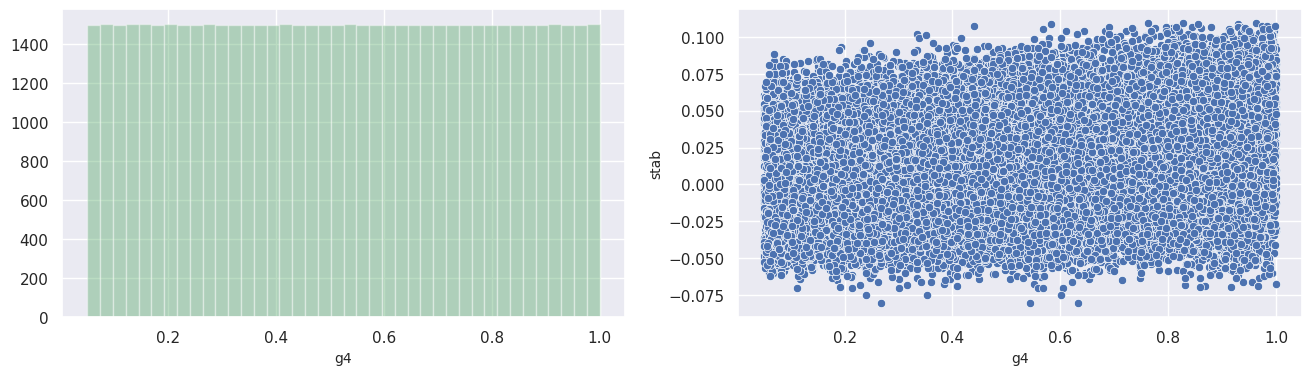

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


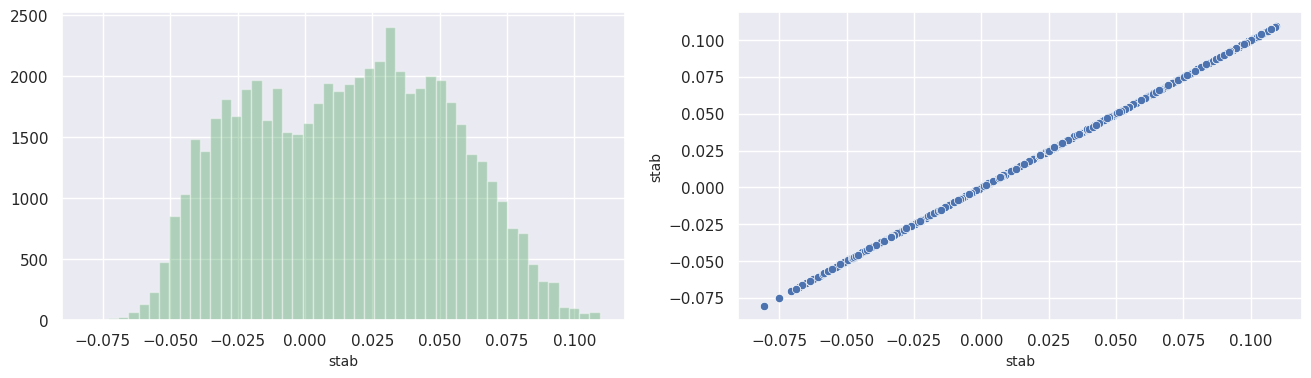

/tmp/ipykernel_47/2482460335.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  f_chart1 = sns.distplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')


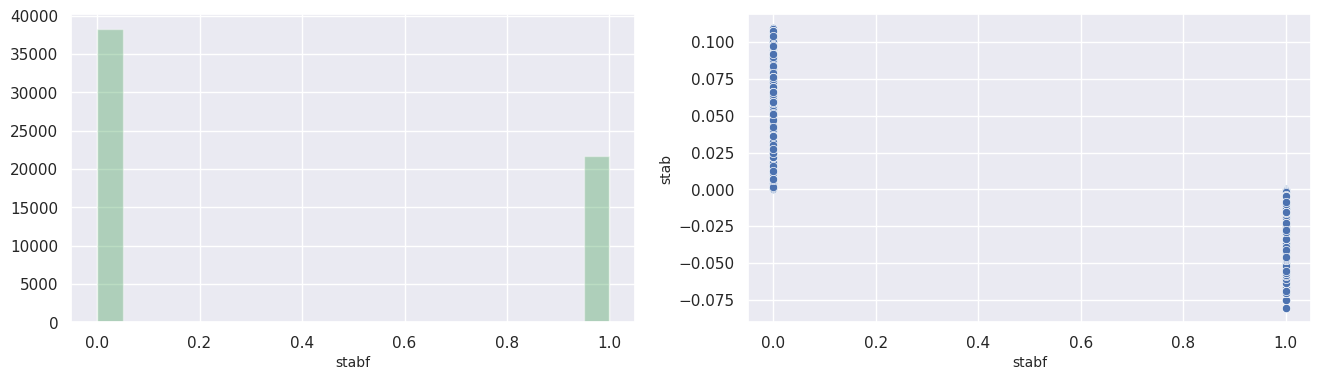

In [14]:
for column in data.columns:
    assessment(data, 'stab', column, -1)

In [15]:
data.p1.skew()

-0.012688423269881656

In [ ]:
#The proportion of observations related to 'unstable' and 'stable' scenarios is mapped.

In [16]:
print(f'Split of "unstable" (0) and "stable" (1) observations in the original dataset:')
print(data['stabf'].value_counts(normalize=True))

Split of "unstable" (0) and "stable" (1) observations in the original dataset:
stabf
0    0.638
1    0.362
Name: proportion, dtype: float64


In [ ]:
#Correlation

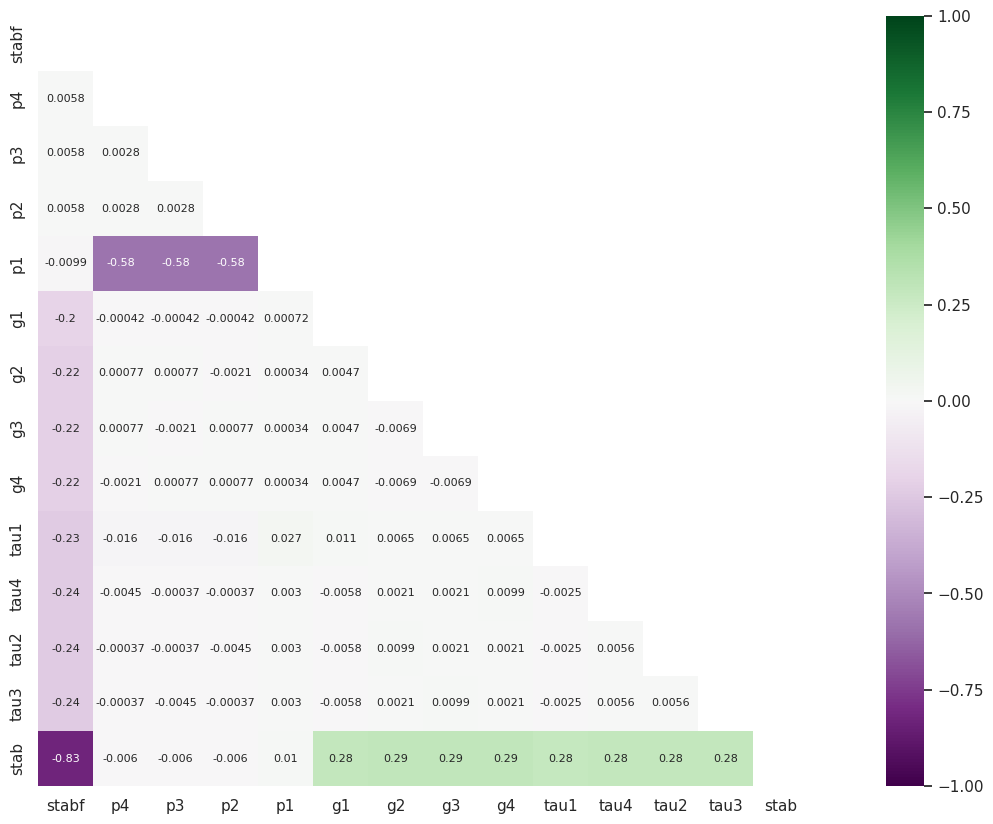

In [17]:
correlation_map(data, 'stabf', 14)

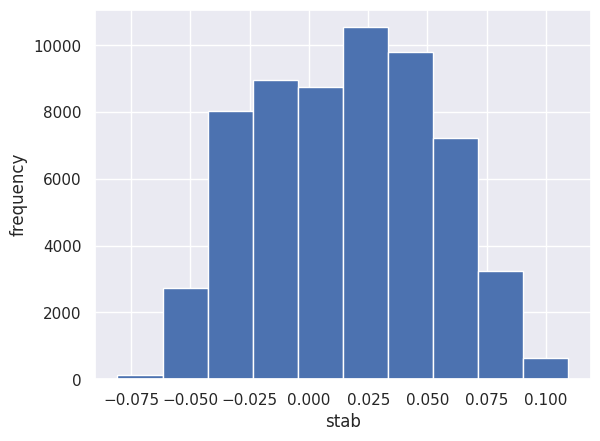

In [18]:
plt.hist(data["stab"])
plt.xlabel("stab")
plt.ylabel("frequency")
plt.show()

<Axes: ylabel='Frequency'>

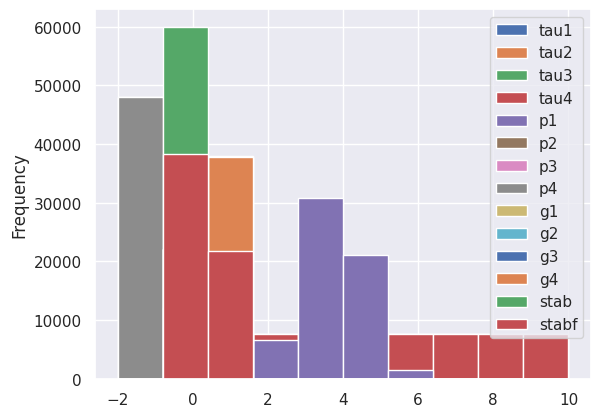

In [19]:
data.plot.hist()

In [ ]:
#Segregating train and test sets

In [17]:
X = data.iloc[:, :12]
y = data.iloc[:, 13]

X_training = X.iloc[:54000, :]
y_training = y.iloc[:54000]

X_testing = X.iloc[54000:, :]
y_testing = y.iloc[54000:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(stabf
 0    0.637556
 1    0.362444
 Name: proportion, dtype: float64,
 stabf
 0    0.642
 1    0.358
 Name: proportion, dtype: float64)

In [18]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

In [ ]:
# Feature scaling

In [19]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

In [ ]:
#Classification model

In [20]:
from xgboost import XGBClassifier, XGBRegressor
clf = XGBClassifier()
clf.fit(X_training, y_training)
print("Classifier trained.")

Classifier trained.


In [27]:
print("Classification Test Accuracy: {:.2f}%".format(clf.score(X_testing, y_testing) * 100))

Classification Test Accuracy: 98.20%


In [21]:
y_pred = clf.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [22]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3797,55
Actual Stable,59,2089


In [31]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_training, y_training)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.0939960082813082, 'max_depth': 7, 'n_estimators': 171, 'subsample': 0.6247556190696052}
Best score:  0.9773518518518518


In [ ]:
#Regression

In [39]:
reg = XGBRegressor()
reg.fit(X_training, y_training)
print("Regressor trained.")

Regressor trained.


In [40]:
print("Regression Test R^2 Score: {:.5f}".format(reg.score(X_testing, y_testing)))

Regression Test R^2 Score: 0.79844


In [ ]:
#Deep Learning

In [ ]:
#The artificial neural network (ANN) architecture depicted below is the optimal one evaluated in this study. It reflects an sequential structure with:

#one input layer (12 input nodes);
#three hidden layers (24, 24 and 12 nodes, respectively);
#one single-node output layer.

In [23]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Third hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1

Model evaluation

169/169 [==============================] - 0s 2ms/step - loss: 0.0932 - accuracy: 0.9607
Round 1 - Loss: 0.0932 | Accuracy: 96.07 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9739
Round 2 - Loss: 0.0624 | Accuracy: 97.39 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 0.9776
Round 3 - Loss: 0.0551 | Accuracy: 97.76 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.9804
Round 4 - Loss: 0.0478 | Accuracy: 98.04 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9798
Round 5 - Loss: 0.0447 | Accuracy: 97.98 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9826
Round 6 - Loss: 0.0451 | Accuracy: 98.26 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9820
Round 7 - Loss: 0.0412 | Accuracy: 98.20 %
169/169 [==============================] - 0s 2ms/step - l

In [ ]:
#Predicting smart grid stability
#After fitting the model to the training set,
#it is time to extract predictions for the testing set and segregate those above the 'threshold' of 0.5 
#('unstable' cases below the threshold, 'stable' cases above it).

In [25]:
y_pred1 = classifier.predict(X_testing)
y_pred1[y_pred1 <= 0.5] = 0
y_pred1[y_pred1 > 0.5] = 1

188/188 [==============================] - 0s 1ms/step


In [26]:
cm1 = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm1

,Predicted Unstable,Predicted Stable
Actual Unstable,3797,55
Actual Stable,59,2089
